<a href="https://colab.research.google.com/github/liamharcombe4/eigen-network/blob/main/EigenNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Imports

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [1]:
#@title Constants

# The number of mesh nodes
n = 200

# The number of randomly generated values for V
m = 40

# True if using the localisation loss 
localisation_loss = True

# The epoch that we refresh our model and apply the localisation loss
refresh_epoch = 2000

lr = 3e-4

n_epochs = 9000

# choose the number of eigenstates to find
num_eigenstates = 4

patience_threshold = 40

loss_threshold = 2000

# True if we want to recompile the model at the refresh epoch
recompile_model = False

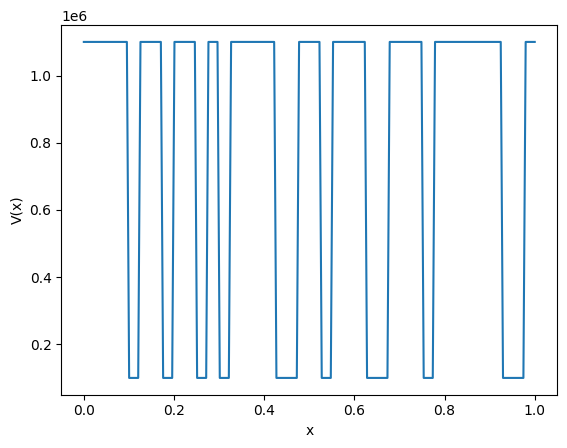

In [3]:
#@title Data


# uniform
# V_init = 10**6*np.random.rand(m,)

# normal
# V_init = 10**6*np.random.normal(1, 0.3, size=(m,))


# lognormal
# V_init = 10**6*np.random.lognormal(0, 1, size=(m,))

# bernoulli
V_init = 10**6*np.random.binomial(1, 0.5, size=(m,)).astype("float64") + 10**5


x = np.linspace(0,1,n)

def V_fun(x):
  return V_init[int(np.floor(x*m - 1))]

V = np.array([V_fun(xn) for xn in x[:-1]] + [V_init[-2]])

old_V = V

true_V_init = np.concatenate(([V_init[-1]], V_init[:-1]))

plt.xlabel("x")
plt.ylabel("V(x)")
plt.plot(x, V)

In [4]:
#@title Functions

ev = tf.Variable(np.ones((1)), trainable=True)
evec_size = n
h = x[1] - x[0]
train_output = tf.ones([n,])
train_inputs = tf.reshape(tf.tile(x, [1]), [1, n])
train_outputs = tf.reshape(tf.tile(train_output, [1]), [1, n])


# Calculate derivative at inner point (non-endpoint). m3 means -3 points from the central point, p3 means p3
# O(h**6)
def innerSecDer(m3,m2,m1,p0,p1,p2,p3):
  return (1/90*m3 - 3/20*m2 + 3/2*m1 - 49/18*p0 + 3/2*p1 - 3/20*p2 + 1/90*p3)/h**2


# Calculate derivative at right endpoint. m2 means -2 points from the calculated point (m0)
# O(h**5)
def rightEndSecDer(m6,m5,m4,m3,m2,m1,m0):
  return (203/45*m0 - 87/5*m1 + 117/4*m2 - 254/9*m3 + 33/2*m4 - 27/5*m5 + 137/180*m6)/h**2

# O(h**5)
def leftEndSecDer(p0,p1,p2,p3,p4,p5,p6):
  return (203/45*p0 - 87/5*p1 + 117/4*p2 - 254/9*p3 + 33/2*p4 - 27/5*p5 + 137/180*p6)/h**2


# Calculate the second derivative vector
def secDerivative(v):
  processed = [leftEndSecDer(v[0],v[1],v[2],v[3],v[4],v[5],v[6]),
                      leftEndSecDer(v[1],v[2],v[3],v[4],v[5],v[6],v[7]),
                      leftEndSecDer(v[2],v[3],v[4],v[5],v[6],v[7],v[8])]
  right_derivatives = [
                       rightEndSecDer(v[-9],v[-8],v[-7],v[-6],v[-5],v[-4],v[-3]),
                       rightEndSecDer(v[-8],v[-7],v[-6],v[-5],v[-4],v[-3],v[-2]),
                       rightEndSecDer(v[-7],v[-6],v[-5],v[-4],v[-3],v[-2],v[-1])]

  unstacked = tf.unstack(v)
  for i in range(0,len(unstacked)-6):
    processed.append(innerSecDer(unstacked[i], unstacked[i+1], unstacked[i+2], unstacked[i+3], unstacked[i+4], unstacked[i+5], unstacked[i+6]))
  
  for der in right_derivatives:
    processed.append(der)

  return tf.stack(processed, 0)
  

def midpoint_area(p1,p2):
  return h*(p2+p1)/2

def integral(tensor):
  processed = []
  unstacked = tf.unstack(tensor)
  for i in range(0,len(unstacked)-1):
    processed.append(midpoint_area(unstacked[i], unstacked[i+1]))

  return tf.math.reduce_sum(tf.stack(processed, 0))



# check if a list of values has converged
# assuming len(list) >= 5
def patience_test(lst):
  assert len(lst) >= 5

  # calculating the backwards difference
  eps = np.abs(1/4*lst[-5] - 4/3*lst[-4] + 3*lst[-3] - 4*lst[-2] + 25/12*lst[-1])

  return eps < patience_threshold


def has_converged(ev_list, evec_list):

  losses_tail = [tf.math.sqrt(tf.math.reduce_mean((ev_list[-1]*evec + secDerivative(evec) - V*evec)**2)) for evec in evec_list[-6:]]

  return patience_test(ev_list) and losses_tail[-1] < loss_threshold and patience_test(losses_tail)


idx_groups = []
idxs_one_hot = tf.Variable(tf.zeros(m))


def collect_idxs(lst, tf_variable=False):
    
    # if the input is a tensorflow variable, convert it to a list
    if tf_variable:
        lst = lst.numpy().tolist()

    if not lst:
        return []
    
    groups = []
    group = [lst[0]]
    
    for i in range(1, len(lst)):
        if lst[i] == lst[i-1] + 1:
            group.append(lst[i])
        else:
            groups.append(group)
            group = [lst[i]]
    
    groups.append(group)
    
    return groups


def assign_idx_groups(evec):
    global idx_groups

    idxs = []
    norms = [integral(segment**2) for segment in split(evec)]
    for i in range(len(norms)):
        if norms[i] > 0.01:
            idxs.append(i)
    
    idx_groups = collect_idxs(idxs)
    # sort idx_groups by the norms, putting the largest first
    idx_groups = sorted(idx_groups, key = lambda lst: sum(norms[i] for i in lst), reverse=True)

    

    # for group in idx_groups_lst:
    #     idx_groups.append(group)


def idxs_to_one_hot(idxs, padding=True):
   
  if padding:
    if idxs[0] != 0:
      idxs = [idxs[0] - 1] + idxs
    if idxs[-1] != m - 1:
      idxs.append(idxs[-1] + 1)
   
  return tf.math.reduce_sum(tf.one_hot(idxs, m), axis=0)


# Split evec into segements to be integrated over to determine localisation regions.
# The split needs include one more element to allow integration of the segments
# to sum to the whole integral
def split(evec):
  segments = []

  unstacked = tf.unstack(evec)

  split_size = n//m
  for i in range(m):
    start = i*split_size
    end = start + split_size
    if i == m-1:
      segments.append(tf.stack(evec[start:end]))
    else:
      segments.append(tf.stack(evec[start:end+1]))

  return segments



# initialise variables
collected_evecs = []
collected_evs = []

ev_list = []
evec_list = []

loc_idx = tf.Variable(-1, dtype=tf.int64)
used_loc_idxs = []

In [ ]:
#@title Model

# generating the eigenstates
%%time

def build_model():
  # Input only the x values
  inputs = tf.keras.Input(shape=(n,1))

  # For eigenvalue
  a = tf.keras.layers.Dense(n, activation="relu")(inputs)
  a = tf.keras.layers.Dense(n, activation="relu")(a)
  a = tf.keras.layers.AveragePooling1D(pool_size=n)(a)
  a = tf.keras.layers.Flatten()(a)
  ev_out = tf.keras.layers.Dense(1)(a)

  # For eigenfunction
  b = tf.keras.layers.Dense(n, activation="relu")(inputs)
  b = tf.keras.layers.Dense(n, activation=tf.math.sin)(b)
  b = tf.keras.layers.Dense(n, activation="relu")(b)
  b = tf.keras.layers.AveragePooling1D(pool_size=n)(b)
  b = tf.keras.layers.Flatten()(b)

  # Standard deviation is increased here to add more noise. This fixes the issue where
  # the network will get confused trying to converge to u(x) and -u(x) at the same time.
  # The added noise places the first u(x) prediction close enough to one of u(x) or -u(x)
  # so that it converges to that one, instead of the first prediction being in the middle of the two.
  evec_out = tf.keras.layers.Dense(n, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1.5))(b)

  outputs = tf.keras.layers.Concatenate(axis=1)([ev_out, evec_out])

  model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model")


  @tf.autograph.experimental.do_not_convert
  def my_loss(_, y_pred):

    ev = y_pred[0][0]
    evec = y_pred[0][1:]
    D = tf.math.sqrt(tf.math.reduce_mean((ev*evec + secDerivative(evec) - V*evec)**2))

    norm = integral(evec**2)

    loss = D + 1/h**2*(evec[0]**2 + evec[-1]**2) + 1/h**3*(norm - 1)**2

    # normalisation loss
    if collected_evecs:
      for old_evec in collected_evecs:
        loss += 1/h**3*integral(evec*old_evec)**2

    if localisation_loss:

      segment_norm = tf.cond(loc_idx >= 0,
                             lambda: tf.math.reduce_sum(idxs_one_hot*[integral(segment**2) for segment in split(evec)]),
                             lambda: norm)
      loss += 1/h**3.25*(segment_norm - norm)**2

    return loss
  

  def my_loss_fn(y_true, y_pred):
    return tf.py_function(my_loss, [y_true, y_pred], tf.int64)

  model.compile(
      loss = my_loss,
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  )

  return model


# eigenstate collection loop
for j in range(num_eigenstates):

  model = build_model()

  converged = False
  

  # training loop
  for i in range(n_epochs):
      # pass tile of the current epoch number to train_outputs to use in the loss function
      tile = np.repeat(float(i), n)
      i_tile = tf.reshape(tf.tile(tile, [1]), [1,n])

      model.fit(train_inputs, i_tile, epochs=1, verbose=0)

      # output the ev and evec predictions throughout the training process
      if (i % 100 == 0):

        ev_fun = K.function([model.layers[0].input], model.layers[-3].output)
        ev = ev_fun(train_inputs)[0][0]
        ev_list.append(ev)

        evec_fun = K.function([model.layers[0].input], model.layers[-2].output)
        evec = evec_fun(train_inputs)[0]
        evec_list.append(evec)

        norm = integral(evec**2)
        D = tf.math.sqrt(tf.math.reduce_mean((ev*evec + secDerivative(evec) - V*evec)**2))

        loss = D + 1/h**2*(evec[0]**2 + evec[-1]**2) + 1/h**3*(norm - 1)**2

        if collected_evecs:
          for old_evec in collected_evecs:
            loss += 1/h**3*integral(evec*old_evec)**2

        if localisation_loss:

          
          # refresh idx_groups
          if i == refresh_epoch:
            assign_idx_groups(evec)
            print("SETTING IDX_GROUPS")
            print("idx_groups:", idx_groups)

            # initialise the model weights again so the model can converge given the new loss function
            if recompile_model:
              model = build_model() 


          if loc_idx.numpy() >= 0:
            segment_norm = tf.math.reduce_sum(idxs_one_hot*[integral(segment**2) for segment in split(evec)])
            
            loss += 1/h**3.25*(segment_norm - norm)**2
          
          # assigning a value to loc_idx
          if i >= refresh_epoch and loc_idx == -1:
            loc_idx.assign(0)
            idxs_one_hot.assign(idxs_to_one_hot(idx_groups[0]))

            # this code was added when idx_groups was held fixed and loc_idx searched through this list
            # if we reach here with loc_idx = -1 then we have searched through all the given locations. 
            # we then want to go through the list again to get higher eigenstates
            if loc_idx == -1:
              used_loc_idxs = []
              if idx_groups:
                loc_idx.assign(0)
              else:
                # else there are no localisation locations so we assign -1
                loc_idx.assign(-1)
              idxs_one_hot.assign(tf.zeros(m))
              idx_groups = []
        

        print("eigenstate:", str(j+1) + ", epoch:", i)
        print("ev:", str(ev) + ", norm:", str(integral(evec**2).numpy()) + ", pde:", str(D.numpy()) + ", loss:", str(loss.numpy()) +  ", loc_idx:", str(loc_idx.numpy()) + ", used_loc_idxs:", used_loc_idxs)

        plt.figure(figsize=(6,3))
        plt.plot(x, evec)
        plt.show()
        
        # collect eigenstates
        if (len(ev_list) > 5) and has_converged(ev_list, evec_list):
          collected_evecs.append(evec)
          collected_evs.append(ev)
          print("EIGENSTATE FOUND")

          # reset used_loc_idxs if we've used all of them
          if loc_idx == len(idx_groups):
            used_loc_idxs = []

          loc_idx.assign(-1)
          idxs_one_hot.assign(tf.zeros(m))

          converged = True

          break
  
  # if the model is out of epochs and hasn't converged
  if not converged:
    collected_evecs.append(evec)
    collected_evs.append(ev)
    print("OUT OF EPOCHS")
    loc_idx.assign(-1)
    idxs_one_hot.assign(tf.zeros(m))

# sort the eigenstates by their eigenvalue
collected_evecs = [collected_evecs[collected_evs.index(ev)] for ev in sorted(collected_evs)]
collected_evs = sorted(collected_evs)
  

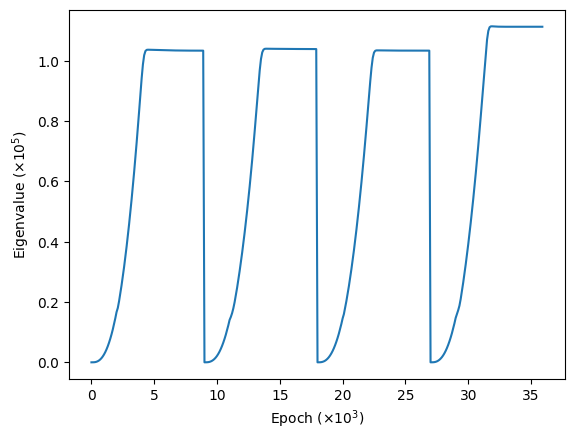

In [6]:
#@title Plotting ev_list

plt.xlabel("Epoch (×$10^3$)")
plt.ylabel("Eigenvalue (×$10^5$)")
plt.plot([epoch/10 for epoch in range(len(ev_list))], [ev/100000 for ev in ev_list])

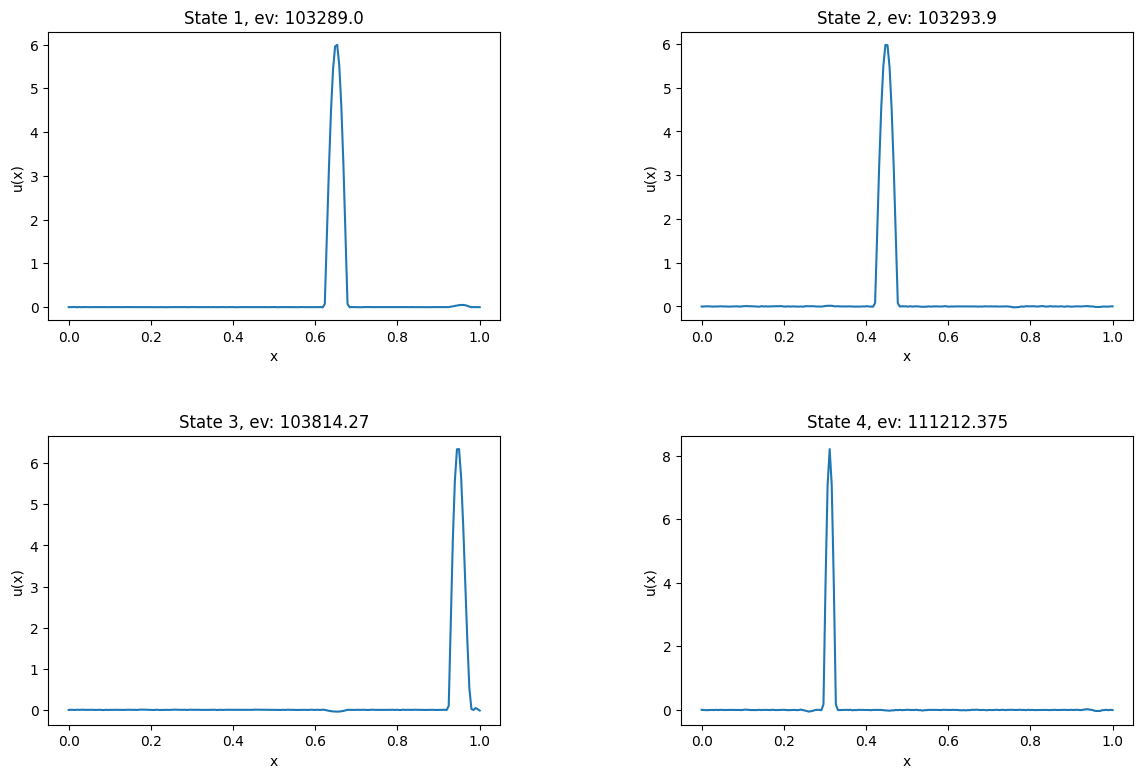

In [7]:
#@title Plotting four eigenstates

# for 4 eigenstates

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 9))

axs[0, 0].plot(x, collected_evecs[0])
axs[0, 1].plot(x, collected_evecs[1])
axs[1, 0].plot(x, collected_evecs[2])
axs[1, 1].plot(x, collected_evecs[3])

axs[0, 0].set_ylabel("u(x)")
axs[0, 1].set_ylabel("u(x)")
axs[1, 0].set_ylabel("u(x)")
axs[1, 1].set_ylabel("u(x)")

axs[0, 0].set_xlabel("x")
axs[0, 1].set_xlabel("x")
axs[1, 0].set_xlabel("x")
axs[1, 1].set_xlabel("x")

axs[0, 0].set_title("State 1, ev: " + str(collected_evs[0]))
axs[0, 1].set_title("State 2, ev: " + str(collected_evs[1]))
axs[1, 0].set_title("State 3, ev: " + str(collected_evs[2]))
axs[1, 1].set_title("State 4, ev: " + str(collected_evs[3]))

fig.subplots_adjust(hspace=0.4, wspace=0.4)


plt.show()

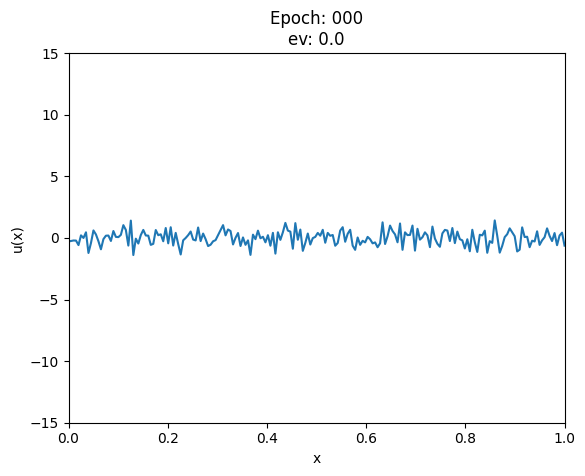

In [7]:
#@title Generating Training Video

from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.set_xlim(0,1)
ax.set_ylim(-15,15)
line, = ax.plot(0,0)

xs = np.array([x for i in range(len(evec_list))])
data = np.array([xs, evec_list])

x_list = x
y_list = []

def animation_frame(i):
  y_list = evec_list[i]

  line.set_xdata(x_list)
  line.set_ydata(y_list)

  ax.set_title("Epoch: " + str(i) + "00\n" + "ev: " + str(np.round(ev_list[i], 0)))

  # y_data = data[i]

  # line.set_xdata(x)
  # line.set_ydata(y_data)
  return line, 

from matplotlib import rc
rc('animation', html='jshtml')

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, len(evec_list), 1), interval=50)

# animation

from IPython.display import HTML
HTML(animation.to_html5_video())

[]

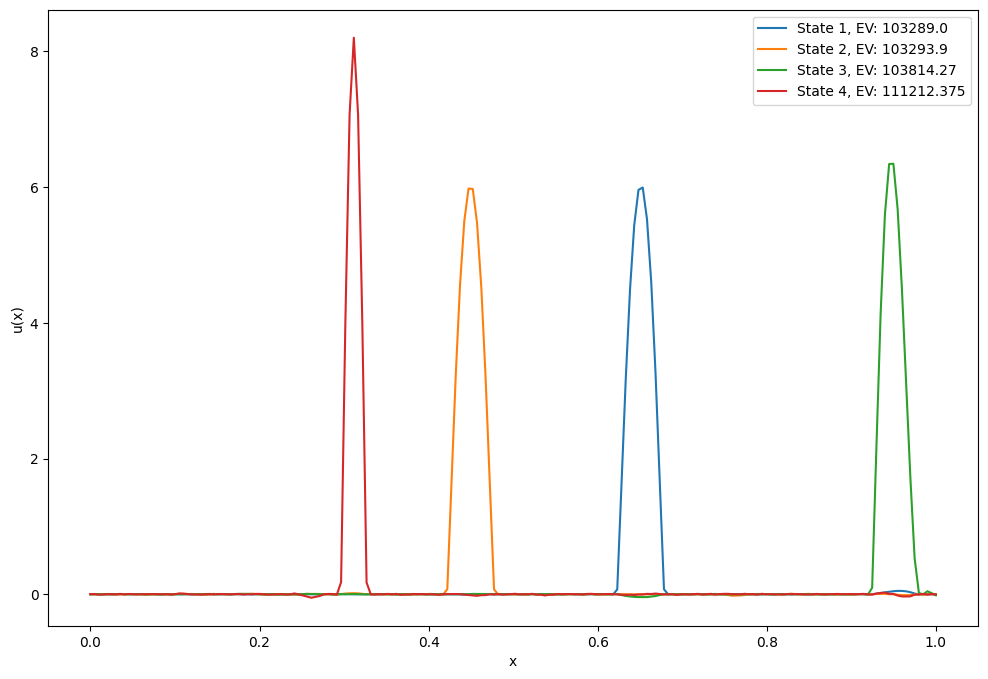

In [9]:
#@title Plotting All Eigenstates

plt.figure(figsize=(12,8))

plt.xlabel("x")
plt.ylabel("u(x)")
for j in range(len(collected_evecs)):
  plt.plot(x, collected_evecs[j], label="State " + str(j+1) + ", EV: " + str(collected_evs[j]))

plt.legend()
plt.plot()